## LSTM vs. 1DConv for timeseries

In this notebook we will use diffrent network architectures to predict the next steps for a time series. We compare 1D convolutional networks with and without didilation rate and LSTMs. We predict the time series for longer times than we trained them on and compare the resuts of the diffrent architectures.

In [1]:
# load required libraries:
import numpy as np
import matplotlib.pyplot as plt
import h5py
%matplotlib inline

import keras 
from keras.models import Sequential
from keras.layers import Dense, Lambda, Convolution1D,LSTM


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### In the next cell we genererate train and validation data. we multiply a fast sine wave with a slow sine wave and add some random noise. The goal is to learn from the past of time series and predict the next 10 steps and later even more than "only"  10.

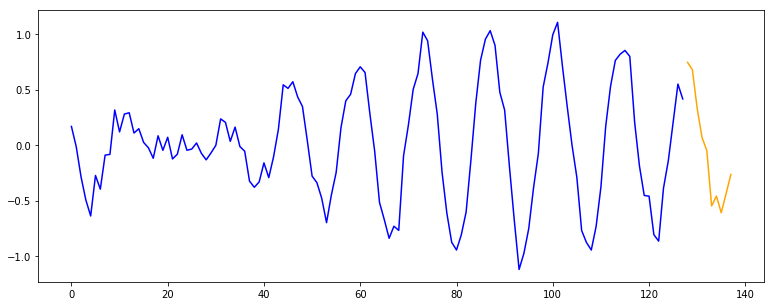

The training data X is the blue line and we want to forecast the next 10 steps Y, the orange line.


In [2]:
np.random.seed(1) # Fixing the seed, so data generation is always the same
seq_length = 128  # Sequence length used for training
look_ahead =  10  # The number of data points the model should predict 


def gen_data(size=1000, noise=0.1,seq_length=128,look_ahead=10): # We create 1000 observations of the process
  s = seq_length + look_ahead
  d = np.zeros((size, s,1))
  for i in range(size):
    start = np.random.uniform(0, 2*np.pi) # Random start point
    d[i,:,0] = np.sin(start + np.linspace(0, 20*np.pi, s)) * np.sin(start + np.linspace(0, np.pi, s)) + np.random.normal(0,noise,s)
  return d[:,0:seq_length], d[:,seq_length:s]


X,Y = gen_data()
for i in range(1):
  plt.figure(num=None, figsize=(13,5))  
  plt.plot(range(0, seq_length),X[i,:,0],'b-')
  plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'b-',color='orange')

plt.show()
print('The training data X is the blue line and we want to forecast the next 10 steps Y, the orange line.')

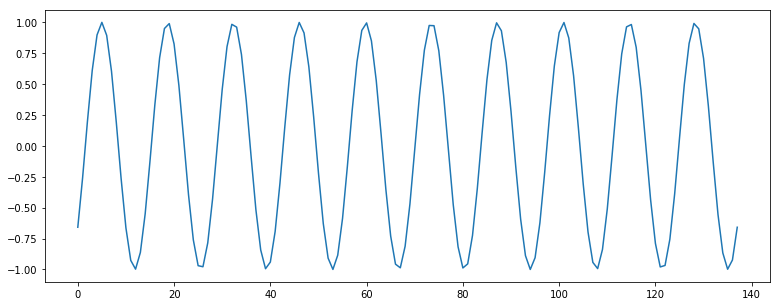

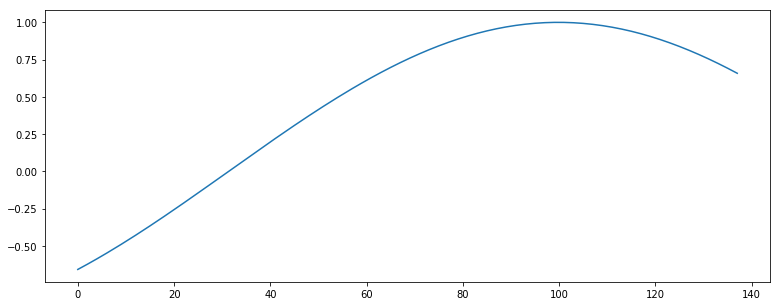

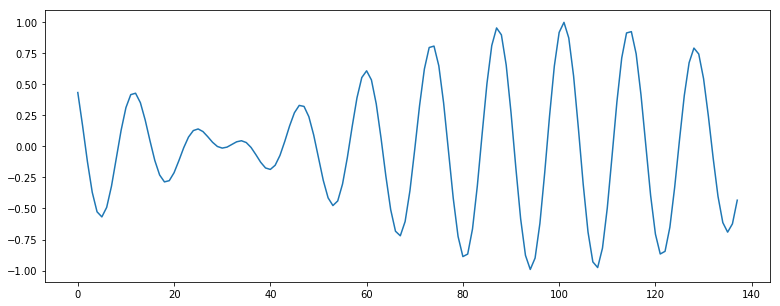

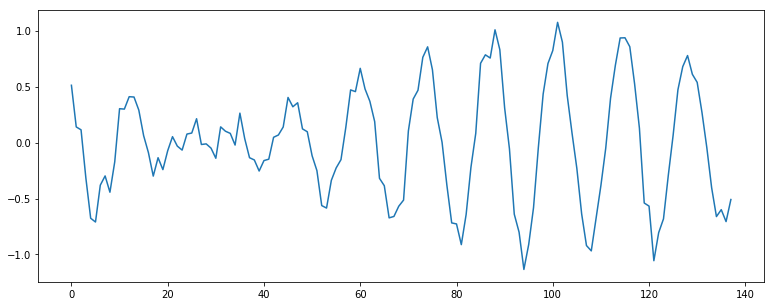

In [3]:
# process:fast sine wave * slow sine wave + random noise
start = np.random.uniform(0, 2*np.pi) # Random start point
s=128+10
plt.figure(figsize=(13,5))  
plt.plot(np.sin(start + np.linspace(0, 20*np.pi, s)))
plt.show()
plt.figure(figsize=(13,5))  
plt.plot(np.sin(start + np.linspace(0, np.pi, s)))
plt.show()
plt.figure(figsize=(13,5))  
plt.plot(np.sin(start + np.linspace(0, 20*np.pi, s))*np.sin(start + np.linspace(0, np.pi, s)))
plt.show()
plt.figure(figsize=(13,5))  
plt.plot(np.sin(start + np.linspace(0, 20*np.pi, s))*np.sin(start + np.linspace(0, np.pi, s))+np.random.normal(0,0.1,s))
plt.show()


In [4]:
print(X.shape)
print(Y.shape)

(1000, 128, 1)
(1000, 10, 1)


### 1D Convolution without dilation rate

In [5]:
def slice(x, slice_length):
    return x[:,-slice_length:,:]
  
model_simple_1Dconv = Sequential()
ks = 5
model_simple_1Dconv.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', input_shape=(128, 1)))
model_simple_1Dconv.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model_simple_1Dconv.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model_simple_1Dconv.add(Convolution1D(filters=32, kernel_size=ks, padding='causal'))
model_simple_1Dconv.add(Dense(1))
model_simple_1Dconv.add(Lambda(slice, arguments={'slice_length':look_ahead}))

model_simple_1Dconv.compile(optimizer='adam', loss='mean_squared_error')
model_simple_1Dconv.summary()


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 128, 32)           192       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 128, 32)           5152      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 128, 32)           5152      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 128, 32)           5152      
_________________________________________________________________
dense_1 (Dense)              (None, 128, 1)            33        
_________________________________________________________________
lambda_1 (Lambda)            (None, 10, 1)             0         
Total params: 15,681
Trainable params: 15,681
Non-trainable

In [6]:
history = model_simple_1Dconv.fit(X[0:800], Y[0:800],
                    epochs=100,
                    batch_size=128,
                    validation_data=(X[800:1000],Y[800:1000]),
                    verbose=1)

Train on 800 samples, validate on 200 samples
Epoch 1/100
800/800 [==============================] - 1s 2ms/step - loss: 0.1171 - val_loss: 0.0345
Epoch 2/100
800/800 [==============================] - 1s 939us/step - loss: 0.0473 - val_loss: 0.0406
Epoch 3/100
800/800 [==============================] - 1s 984us/step - loss: 0.0380 - val_loss: 0.0386
Epoch 4/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0349 - val_loss: 0.0316
Epoch 5/100
800/800 [==============================] - 1s 900us/step - loss: 0.0335 - val_loss: 0.0286
Epoch 6/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0314 - val_loss: 0.0270
Epoch 7/100
800/800 [==============================] - 1s 896us/step - loss: 0.0297 - val_loss: 0.0258
Epoch 8/100
800/800 [==============================] - 1s 847us/step - loss: 0.0283 - val_loss: 0.0249
Epoch 9/100
800/800 [==============================] - 1s 851us/step - loss: 0.0273 - val_loss: 0.0247
Epoch 10/100
800/800 [===========

Epoch 80/100
800/800 [==============================] - 1s 902us/step - loss: 0.0236 - val_loss: 0.0237
Epoch 81/100
800/800 [==============================] - 1s 968us/step - loss: 0.0243 - val_loss: 0.0223
Epoch 82/100
800/800 [==============================] - 1s 966us/step - loss: 0.0237 - val_loss: 0.0223
Epoch 83/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0240 - val_loss: 0.0218
Epoch 84/100
800/800 [==============================] - 1s 873us/step - loss: 0.0237 - val_loss: 0.0221
Epoch 85/100
800/800 [==============================] - 1s 929us/step - loss: 0.0238 - val_loss: 0.0225
Epoch 86/100
800/800 [==============================] - 1s 913us/step - loss: 0.0243 - val_loss: 0.0220
Epoch 87/100
800/800 [==============================] - 1s 965us/step - loss: 0.0243 - val_loss: 0.0225
Epoch 88/100
800/800 [==============================] - 1s 959us/step - loss: 0.0244 - val_loss: 0.0221
Epoch 89/100
800/800 [==============================] - 1s 935us/s

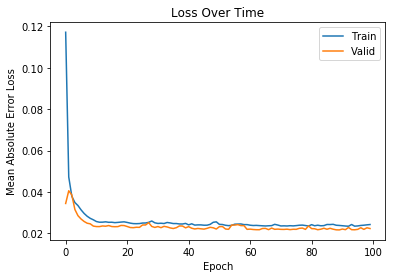

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

#### Now we want to use the trained model to predict for the next 10 steps, remeber that is what the model was trained on. But we want to predict for longer than just 10 steps, we wil  just predict the next 10 steps and take the predictions as new "true" observerations and feed these values into the model, when we do that we can predict for any length we want. In the next cell we will predict the next 10 and 80 steps.

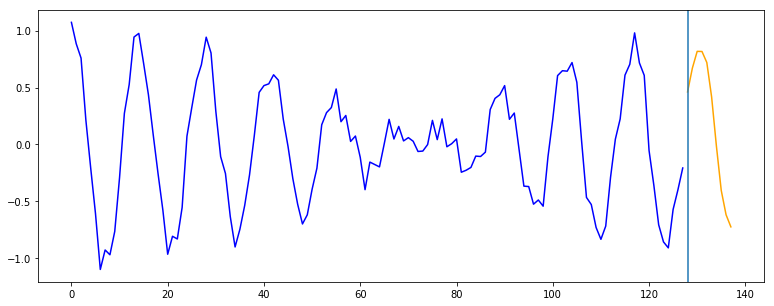

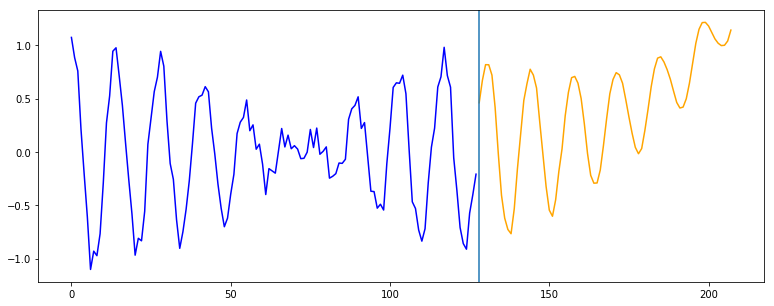

In [8]:
i=950
steps = 1
pred = np.empty(0)
data = X[i:i+1]
model = model_simple_1Dconv

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)

i=950
steps = 8
pred = np.empty(0)
data = X[i:i+1]
model = model_simple_1Dconv

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)



### 1D Convolution with dilation rate


In [9]:
model_simple_1Dconv_w_d = Sequential()
ks = 5
model_simple_1Dconv_w_d.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=1, input_shape=(128, 1)))
model_simple_1Dconv_w_d.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=2))
model_simple_1Dconv_w_d.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=4))
model_simple_1Dconv_w_d.add(Convolution1D(filters=32, kernel_size=ks, padding='causal', dilation_rate=8))
model_simple_1Dconv_w_d.add(Dense(1))
model_simple_1Dconv_w_d.add(Lambda(slice, arguments={'slice_length':look_ahead}))

model_simple_1Dconv_w_d.compile(optimizer='adam', loss='mean_squared_error')
model_simple_1Dconv_w_d.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 128, 32)           192       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 128, 32)           5152      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 128, 32)           5152      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 128, 32)           5152      
_________________________________________________________________
dense_2 (Dense)              (None, 128, 1)            33        
_________________________________________________________________
lambda_2 (Lambda)            (None, 10, 1)             0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model_simple_1Dconv_w_d.fit(X[0:800], Y[0:800],
                    epochs=100,
                    batch_size=128,
                    validation_data=(X[800:1000],Y[800:1000]),
                    verbose=1)

Train on 800 samples, validate on 200 samples
Epoch 1/100
800/800 [==============================] - 2s 2ms/step - loss: 0.1680 - val_loss: 0.0485
Epoch 2/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0447 - val_loss: 0.0291
Epoch 3/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0248 - val_loss: 0.0176
Epoch 4/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0164 - val_loss: 0.0164
Epoch 5/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0162 - val_loss: 0.0128
Epoch 6/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0138 - val_loss: 0.0136
Epoch 7/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0134 - val_loss: 0.0121
Epoch 8/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0129 - val_loss: 0.0117
Epoch 9/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0127 - val_loss: 0.0120
Epoch 10/100
800/800 [=======================

Epoch 81/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0119 - val_loss: 0.0109
Epoch 82/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0118 - val_loss: 0.0107
Epoch 83/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0118 - val_loss: 0.0107
Epoch 84/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0117 - val_loss: 0.0109
Epoch 85/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0117 - val_loss: 0.0109
Epoch 86/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0118 - val_loss: 0.0107
Epoch 87/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0117 - val_loss: 0.0107
Epoch 88/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0117 - val_loss: 0.0108
Epoch 89/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0118 - val_loss: 0.0107
Epoch 90/100
800/800 [==============================] - 1s 1ms/step - loss: 0.0120

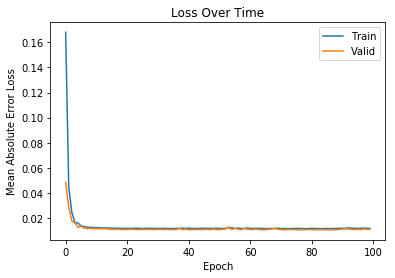

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

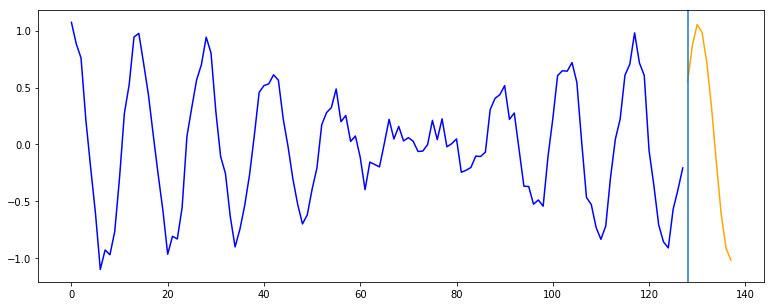

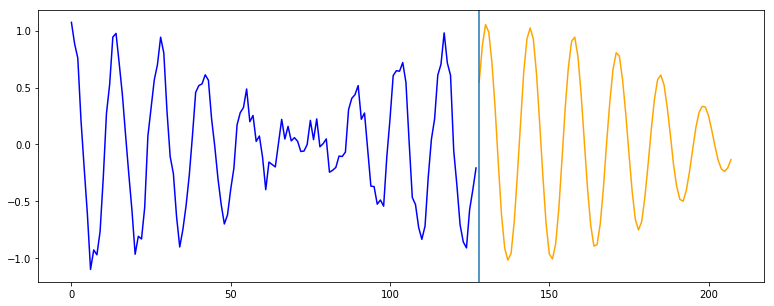

In [12]:
i=950
steps = 1
pred = np.empty(0)
data = X[i:i+1]
model = model_simple_1Dconv_w_d

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)

i=950
steps = 8
pred = np.empty(0)
data = X[i:i+1]
model = model_simple_1Dconv_w_d

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)



### Simple LSTM

In [13]:
model_simple_LSTM = Sequential()

model_simple_LSTM.add(LSTM(32,return_sequences=True,input_shape=(128,1)))
model_simple_LSTM.add((Dense(1)))
model_simple_LSTM.add(Lambda(slice, arguments={'slice_length':look_ahead}))

model_simple_LSTM.summary()
model_simple_LSTM.compile(optimizer='adam', loss='mean_squared_error')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 32)           4352      
_________________________________________________________________
dense_3 (Dense)              (None, 128, 1)            33        
_________________________________________________________________
lambda_3 (Lambda)            (None, 10, 1)             0         
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


#### To train the LSTM model takes alot time, so we just load a trained model after 200 epochs

In [14]:
#history = model_simple_LSTM.fit(X[0:800], Y[0:800],
#                    epochs=200,
#                    batch_size=128,
#                    validation_data=(X[800:1000],Y[800:1000]),
#                    verbose=1)

In [15]:
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#
#plt.xlabel('Epoch')
#plt.ylabel('Mean Absolute Error Loss')
#plt.title('Loss Over Time')
#plt.legend(['Train','Valid'])

In [16]:
#model_simple_LSTM.save('../data/models/simple_lstm_200_epochs.hdf5')  


In [17]:
# we load the traind simple lstm model (for time reasons)
from keras.models import load_model
model_simple_LSTM = load_model('../data/models/simple_lstm_200_epochs.hdf5')
model_simple_LSTM.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128, 32)           4352      
_________________________________________________________________
dense_6 (Dense)              (None, 128, 1)            33        
_________________________________________________________________
lambda_6 (Lambda)            (None, 10, 1)             0         
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


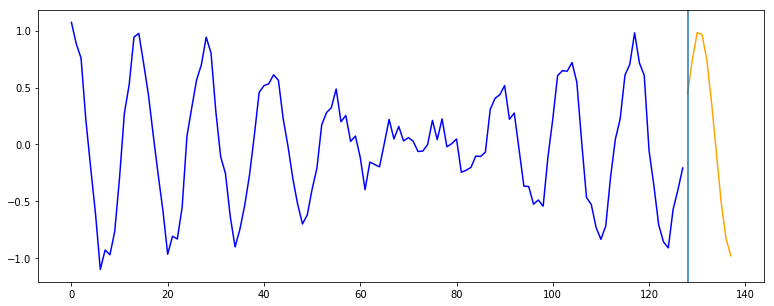

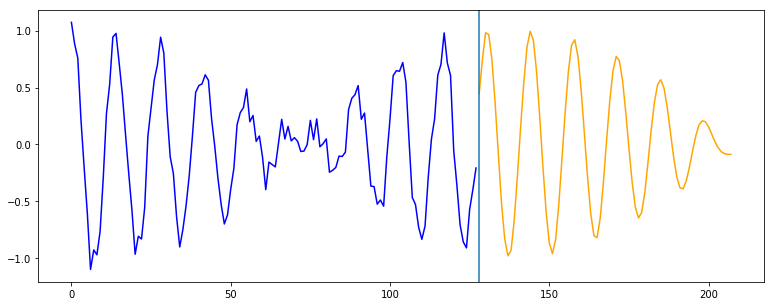

In [18]:
i=950
steps = 1
pred = np.empty(0)
data = X[i:i+1]
model = model_simple_LSTM

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)

i=950
steps = 8
pred = np.empty(0)
data = X[i:i+1]
model = model_simple_LSTM

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)



### 1D Convolution with dilation rate vs LSTM for very long prediction


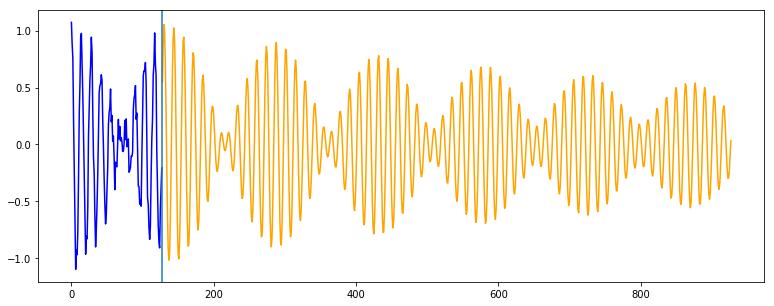

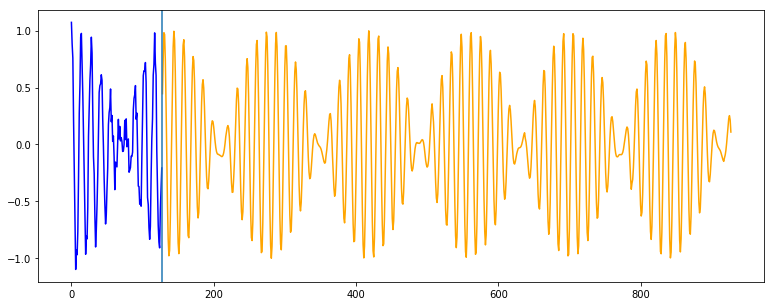

In [19]:
i=950
steps = 80
pred = np.empty(0)
data = X[i:i+1]
model = model_simple_1Dconv_w_d

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)


i=950
steps = 80
pred = np.empty(0)
data = X[i:i+1]
model = model_simple_LSTM

for j in range(0,steps):
  res = model.predict(data)[0]
  res = res.reshape(10)
  data=(np.concatenate((data[0:1].reshape(128),res)))
  data=data[-128:]
  data=data.reshape((1,128,1))
  #data=data.reshape(1,128+(j)*10,1)[-128:]
  pred=np.append(pred,res)
data=X[i:i+1]  
plt.figure(num=None, figsize=(13,5))
plt.plot(range(0,128),np.concatenate((data[0:1].reshape(128),pred))[0:128],color='blue')
plt.plot(range(128,128+steps*10),np.concatenate((data[0:1].reshape(128),pred))[128:128+steps*10],color='orange')
plt.axvline(x=128)
